In [1]:
import pandas as pd
import numpy as np
import random
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
import seaborn as sns

In [2]:
dir_dados = '../2_dados/'
arq_treino_sumario = dir_dados + '/treino_teste/treino_sumario.parquet'
arq_treino = dir_dados + '/treino_teste/treino.npy'
arq_teste_sumario = dir_dados + '/treino_teste/teste_sumario.parquet'
arq_teste = dir_dados + '/treino_teste/teste.npy'

In [3]:
plt.rcParams['figure.figsize'] = (10, 5)
random.seed(1)

#### Abre arquivos

In [4]:
#treino_idx = pd.read_parquet(arq_treino_sumario)   # Informações do treino (fase, target)
teste_idx = pd.read_parquet(arq_teste_sumario)      # Possui o target do teste

In [5]:
teste_idx['target'].value_counts()

0    140
1     35
Name: target, dtype: int64

In [6]:
treino = np.load(arq_treino)    # Todos da classe normal (0)
teste = np.load(arq_teste)      # 30% da classe normal (0), 100% das anomalias

In [7]:
treino = treino.reshape(-1, treino.shape[1], 1)
teste = teste.reshape(-1, teste.shape[1], 1)

In [8]:
print('Dimensão de Treino:', treino.shape)
print('Dimensão de Teste:', teste.shape)

Dimensão de Treino: (326, 800000, 1)
Dimensão de Teste: (175, 800000, 1)


In [9]:
y_true = teste_idx['target'].to_numpy()

### Convolutional Autoencoder

#### Cria sequências

In [10]:
time_steps = 10000
qtd_series_treino = 3

In [11]:
ultimo_indice = treino.shape[1] - time_steps
meio_indice = time_steps // 2
x_train = []
for serie in treino[:qtd_series_treino]:
    for i in range(0, ultimo_indice, meio_indice):
        fatia = serie[i:i + time_steps]
        x_train.append(fatia)
x_train = np.array(x_train)

In [12]:
print('Dimensão de x_train:', x_train.shape)

Dimensão de x_train: (474, 10000, 1)


#### Modelo

In [13]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 5000, 32)          256       
_________________________________________________________________
dropout (Dropout)            (None, 5000, 32)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2500, 16)          3600      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 5000, 16)          1808      
_________________________________________________________________
dropout_1 (Dropout)          (None, 5000, 16)          0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 10000, 32)         3616      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 10000, 1)          2

In [14]:
history = model.fit(
    x_train,
    x_train,
    epochs=100,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/100
4/4 [==============================] - 2s 551ms/step - loss: 0.9014 - val_loss: 0.3368
Epoch 2/100
4/4 [==============================] - 1s 266ms/step - loss: 0.7521 - val_loss: 0.2382
Epoch 3/100
4/4 [==============================] - 1s 269ms/step - loss: 0.5652 - val_loss: 0.1390
Epoch 4/100
4/4 [==============================] - 1s 272ms/step - loss: 0.4191 - val_loss: 0.1236
Epoch 5/100
4/4 [==============================] - 1s 272ms/step - loss: 0.3373 - val_loss: 0.0513
Epoch 6/100
4/4 [==============================] - 1s 279ms/step - loss: 0.1472 - val_loss: 0.0174
Epoch 7/100
4/4 [==============================] - 1s 282ms/step - loss: 0.0636 - val_loss: 0.0520
Epoch 8/100
4/4 [==============================] - 1s 279ms/step - loss: 0.0916 - val_loss: 0.0230
Epoch 9/100
4/4 [==============================] - 1s 291ms/step - loss: 0.0393 - val_loss: 0.0101
Epoch 10/100
4/4 [==============================] - 1s 292ms/step - loss: 0.0419 - val_loss: 0.0083
Epoch 11/

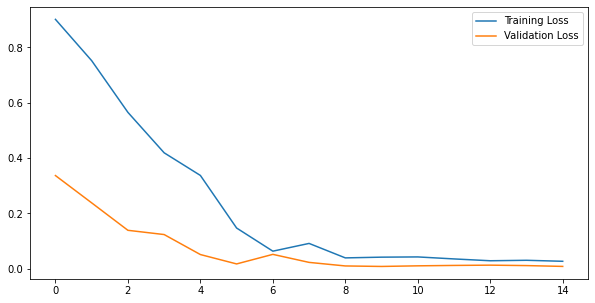

In [15]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

#### Detecção de anomalias

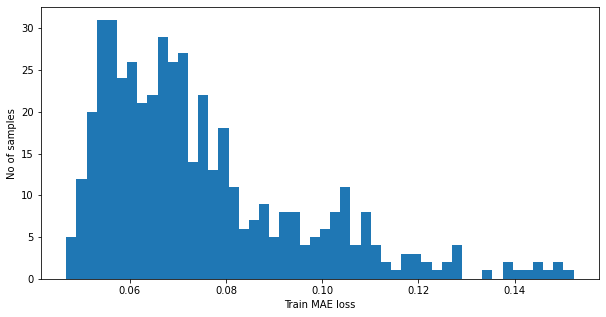

In [16]:
# Obtem o MAE do treino
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

In [17]:
# Obtem o threshold do erro de reconstrução
threshold = np.max(train_mae_loss)
print("Threshold do erro de reconstrução: ", threshold)

Threshold do erro de reconstrução:  0.1522796462474325


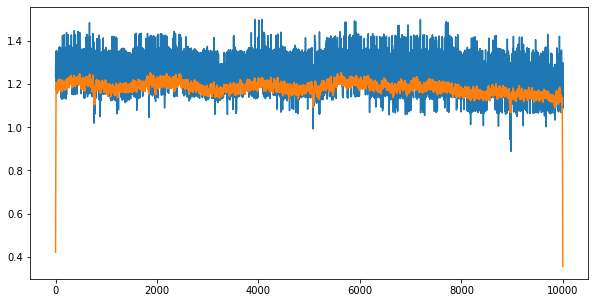

In [18]:
# Verifica o aprendizado da primeira sequência do treino
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

### Teste

In [19]:
def criarSequencia(serie, time_steps=time_steps):
    ultimo_indice = len(serie) - time_steps
    meio_indice = time_steps // 2
    x_train = []
    for i in range(0, ultimo_indice, meio_indice):
        fatia = serie[i:i + time_steps]
        x_train.append(fatia)
    x_train = np.array(x_train)
    return x_train

#### Sem anomalia

In [20]:
# Cria sequências a partir do teste
x_test = criarSequencia(teste[0])   # Uma amostra sem anomalia
print("Dimensão de x_test: ", x_test.shape)

Dimensão de x_test:  (158, 10000, 1)


In [21]:
# Obtem o MAE do teste
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

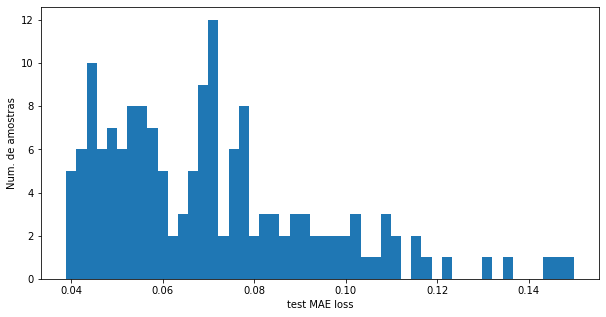

In [22]:
plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("Num. de amostras")
plt.show()

In [23]:
# Detecta todas as amostras que são anomalias
anomalias = test_mae_loss > threshold
print("Número de amostras anômalas:", np.sum(anomalias))
#print("Índices de amostras anômalas:", np.where(anomalias))

Número de amostras anômalas: 0


#### Com anomalia

In [24]:
# Cria sequências a partir das séries de teste
x_test = criarSequencia(teste[-1])     # Uma amostra com anomalia
print("Dimensão de x_test: ", x_test.shape)

Dimensão de x_test:  (158, 10000, 1)


In [25]:
# Obtem o MAE do teste
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

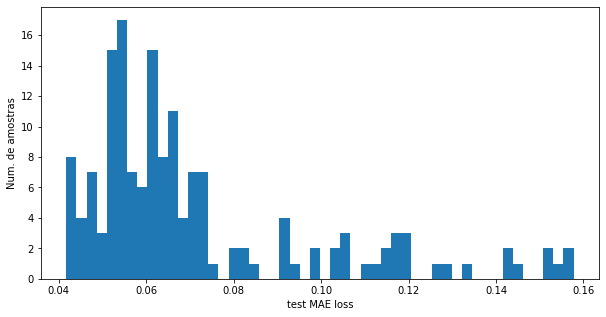

In [26]:
plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("Num. de amostras")
plt.show()

In [27]:
# Detecta todas as amostras que são anomalias
anomalias = test_mae_loss > threshold
print("Número de amostras anômalas:", np.sum(anomalias))
#print("Índices de amostras anômalas:", np.where(anomalias))

Número de amostras anômalas: 4


#### Métricas

In [28]:
y_pred = []
for serie in tqdm(teste):
    # Cria sequência e prediz classe
    x_test = criarSequencia(serie)
    x_test_pred = model.predict(x_test)
    # Calcula o MAE comparando entrada com saída
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
    test_mae_loss = test_mae_loss.reshape((-1))
    # Obtem qtd de anomalias
    qtd_anomalias = np.sum(test_mae_loss > threshold)
    y_pred.append(1 if qtd_anomalias > 0 else 0)
y_pred = np.array(y_pred)

In [29]:
metrics = precision_recall_fscore_support(y_true, y_pred, pos_label=1, average='binary')
print('Precisão:', round(metrics[0], 2))
print('Recall:', round(metrics[1], 2))
print('f1:', round(metrics[2], 2))

Precisão: 0.21
Recall: 0.63
f1: 0.32


In [30]:
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)

[[58 82]
 [13 22]]


<AxesSubplot:>

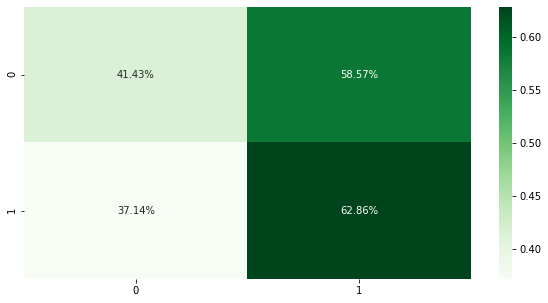

In [31]:
sns.heatmap(cf_matrix/cf_matrix.sum(axis=1)[:, np.newaxis], annot=True, fmt='.2%', cmap='Greens')

In [32]:
print(classification_report(y_true, y_pred, target_names=['Normal', 'Descarga Parcial']))

                  precision    recall  f1-score   support

          Normal       0.82      0.41      0.55       140
Descarga Parcial       0.21      0.63      0.32        35

        accuracy                           0.46       175
       macro avg       0.51      0.52      0.43       175
    weighted avg       0.70      0.46      0.50       175

